# Overview
This notebook is the 2nd notebook in my Pytorch Learning journey. I am following the [ZeroToMastery Pytorch course](https://www.learnpytorch.io/02_pytorch_classification/).

# Classification in Pytorch

In [101]:
import torch
# let's get to business
## first set up the device

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

RANDOM_SEED = 69

torch.manual_seed(RANDOM_SEED)

cuda


In [102]:
# let's start by creating a non-linear classification dataset using sklearn
from sklearn.datasets import make_circles
import pandas as pd

n_samples = 10000
X, Y = make_circles(n_samples, noise=0.05, random_state=RANDOM_SEED, factor=0.75)

data = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "y": Y})
print(data.head())

         X1        X2  y
0  0.715724  0.237047  1
1 -0.805451  0.144517  1
2 -0.143639  1.058746  0
3  0.974003 -0.130973  0
4  0.438967  0.699867  1


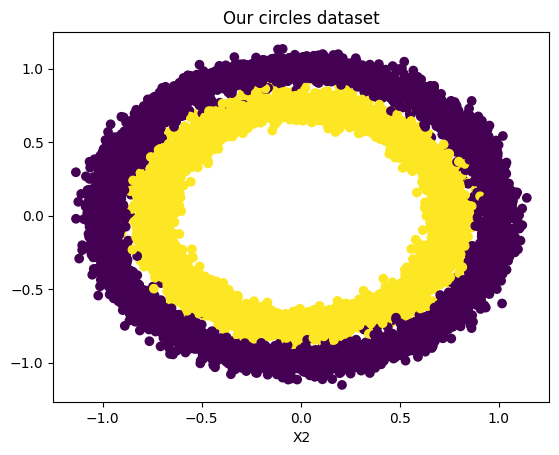

In [103]:
# plotting the data never hurt anybody!!!
import matplotlib.pylab as plt

plt.scatter(x=X[:, 0], y=X[:, 1], c=Y)
plt.xlabel('X1')
plt.xlabel('X2')
plt.title('Our circles dataset')
plt.show()


In [104]:
# let's get to work converting data to tensors and splitting the data and stuff...

X = torch.from_numpy(X).type(torch.float)# convert to a pytorch tensor and make sure the type is float
Y = torch.from_numpy(Y).type(torch.float)

# let's get ourselves a decent split
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=RANDOM_SEED, stratify=Y) # make sure the classes' distributions are the same in both train and test datasets

# set the device of the tensors
X_train = X_train.to(device)
X_test = X_test.to(device)
Y_train = Y_train.to(device)
Y_test = Y_test.to(device)

In [105]:
# let's create a function for calculating the accuracy of certain predictions given the target values
def accuracy_fn(y_true: torch.tensor, y_pred: torch.tensor, precision:int=3):
    
    # make sure to squeeze the tensors
    y_t = torch.squeeze(y_true)
    y_p = torch.squeeze(y_pred)
    assert y_t.size() == y_p.size()
    
    return round(torch.eq(y_t, y_p).type(torch.float).mean().item(), precision) * 100 

In [138]:
# let's first create a linear model
from torch import nn

class LinearModel(nn.Module):
    def __init__(self, input_shape:int, num_classes:int, optimizer=None, metric=None, threshold=0.5, epochs:int=20, epochs_per_log:int=5):
        super().__init__()
        # let's save the values in a model's fields
        self.num_classes = num_classes
        self.input_shape = input_shape

        # let's make a 3 layer model

        self.layer_1 = nn.Linear(in_features=input_shape, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=8)
        self.layer_3 = nn.Linear(in_features=8, out_features=1 if num_classes <= 2 else num_classes)

        self.output_layer = nn.Sigmoid() if num_classes <= 2 else nn.Softmax(dim=-1)

        # set the threshold to consider in binary classification
        self.threshold = threshold

        # let's see how we can add some loss functions
        self.loss_function = nn.BCEWithLogitsLoss() if num_classes <= 2 else nn.CrossEntropyLoss()

        # the optimizer, the default is the stochastic Gradient descent this time
        self.optimizer = torch.optim.SGD(params=self.parameters(), lr=0.08) if optimizer is None else optimizer(params=self.parameters())

        # set the metric function (accuracy / precision / f1 score...)
        self.metric = accuracy_fn if metric is None else metric 

        # set the epochs' parameters        
        self.epochs = epochs # the number of epochs in the training loop
        self.epochs_per_log = epochs_per_log # how often should the error be displayed

        # create fields to save the progress
        self.train_losses = []
        self.train_metrics = []
        self.test_losses = []
        self.test_metrics = []

    def forward(self, x:torch.tensor) -> torch.tensor: 
        return self.layer_3(self.layer_2(self.layer_1(x))).squeeze()

    def test_model(self, X_test: torch.tensor, Y_test: torch.tensor, classes_only=True):
        # set the eval flag
        self.eval()
        # use the inference context manager
        with torch.inference_mode():
            y_logits = self(X_test)
            
            # convert the logits to probabilities by applying the output layer activation function
            y_probs = self.output_layer(y_logits) 
            # convert the probabilitie to classes
            y_pred = (y_probs >= self.threshold).type(torch.float) if self.num_classes <= 2 else torch.argmax(y_probs, dim=-1)
            
            # calculate the loss: for both multi and binary classification, the loss function is evaluated with the logits !!!!
            y_test_loss = self.loss_function(y_logits, Y_test)
            # the metric function is applied on the predictions
            y_test_metric = self.metric(Y_test, y_pred)
            # the returned values are tensors
            self.test_losses.append(y_test_loss.detach().item())
            self.test_metrics.append(y_test_metric)
            # decide what to return depending only the classes_only argument        
            if classes_only:
                return y_pred
            return y_pred, y_test_loss, y_test_metric


    # let's add training and testing loops
    def train_model(self, X_train: torch.tensor, Y_train: torch.tensor, X_test: torch.tensor=None, Y_test: torch.tensor=None):
        # first thing clear the saved previous losses and accuracies
        self.train_losses.clear()
        self.train_metrics.clear()
        self.test_losses.clear() 
        self.test_metrics.clear()

        # loop through the epochs
        for epo in range(1, self.epochs + 1):
            # setting the model's model to train mode as we can switch to the test mode during certain epochs
            self.train()

            # calculate the probabilities
            y_logits = self(X_train)
            
            y_probs = self.output_layer(y_logits) 
            # convert the probabilitie to classes
            y_pred = (y_probs >= self.threshold).type(torch.float) if self.num_classes <= 2 else torch.argmax(y_probs, dim=-1)

            # calculating the loss function
            current_loss = self.loss_function(y_logits, Y_train)
            # calculate the classification's metric
            current_metric = self.metric(Y_train, y_pred)
            
            # save them in the corresponding list 
            self.train_losses.append(current_loss.detach().item())
            self.train_metrics.append(current_metric)

            # set zero gradient
            self.optimizer.zero_grad()
            current_loss.backward()
            self.optimizer.step()
            

            # if the test data is passed, then call the test loop
            if X_test is not None and Y_test is not None:
                # calculate the test loss and metrics
                self.test_model(X_test, Y_test)

                # display the necessary log
                if epo % self.epochs_per_log == 0:
                    print(f"The Train loss after {epo} epochs: {round(self.train_losses[-1], 3)}. The train metric after {epo} epochs: {round(self.train_metrics[-1], 3)}")
                    print(f"The Test loss after {epo} epochs: {round(self.test_losses[-1], 3)}. The test metric after {epo} epochs: {round(self.test_metrics[-1], 3)}")
                    print()


In [139]:
m1 = LinearModel(input_shape=2, num_classes=2, epochs=200, epochs_per_log=20)
m1.to(device)
m1.train_model(X_train, Y_train, X_test, Y_test)

The Train loss after 20 epochs: 0.696. The train metric after 20 epochs: 52.6
The Test loss after 20 epochs: 0.697. The test metric after 20 epochs: 52.4

The Train loss after 40 epochs: 0.695. The train metric after 40 epochs: 51.1
The Test loss after 40 epochs: 0.696. The test metric after 40 epochs: 51.7

The Train loss after 60 epochs: 0.695. The train metric after 60 epochs: 50.9
The Test loss after 60 epochs: 0.695. The test metric after 60 epochs: 51.2

The Train loss after 80 epochs: 0.694. The train metric after 80 epochs: 50.9
The Test loss after 80 epochs: 0.695. The test metric after 80 epochs: 51.1

The Train loss after 100 epochs: 0.694. The train metric after 100 epochs: 50.8
The Test loss after 100 epochs: 0.695. The test metric after 100 epochs: 51.1

The Train loss after 120 epochs: 0.694. The train metric after 120 epochs: 50.9
The Test loss after 120 epochs: 0.694. The test metric after 120 epochs: 50.6

The Train loss after 140 epochs: 0.694. The train metric after

In [140]:
# let's download some helper functions for better re-use
import requests
import os

if os.path.isfile(os.path.join(os.getcwd(), 'helper_functions.py')):
    print("the file is already downloaded")
else:
    req = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open('helper_functions.py', 'wb') as f:
        f.write(req.content)

the file is already downloaded


In [141]:
# let's improve the model a bit to see how things work

class ANN(LinearModel):
    def __init__(self, input_shape: int, num_classes: int, optimizer=None, metric=None, threshold=0.5, epochs: int = 20, epochs_per_log: int = 5):
        super().__init__(input_shape, num_classes, optimizer, metric, threshold, epochs, epochs_per_log)
        self.relu_layer = nn.ReLU(inplace=True)

    def forward(self, x: torch.tensor) -> torch.tensor:
        return self.layer_3(self.relu_layer(self.layer_2(self.relu_layer(self.layer_1(x))))).squeeze()

In [142]:
m2 = ANN(input_shape=2, num_classes=2, epochs=1000, epochs_per_log=50)
m2.to(device)
m2.train_model(X_train, Y_train, X_test, Y_test)

The Train loss after 50 epochs: 0.692. The train metric after 50 epochs: 50.0
The Test loss after 50 epochs: 0.692. The test metric after 50 epochs: 50.0

The Train loss after 100 epochs: 0.69. The train metric after 100 epochs: 54.6
The Test loss after 100 epochs: 0.691. The test metric after 100 epochs: 52.0

The Train loss after 150 epochs: 0.689. The train metric after 150 epochs: 52.8
The Test loss after 150 epochs: 0.69. The test metric after 150 epochs: 51.6

The Train loss after 200 epochs: 0.688. The train metric after 200 epochs: 53.1
The Test loss after 200 epochs: 0.689. The test metric after 200 epochs: 52.3

The Train loss after 250 epochs: 0.687. The train metric after 250 epochs: 53.3
The Test loss after 250 epochs: 0.687. The test metric after 250 epochs: 52.6

The Train loss after 300 epochs: 0.685. The train metric after 300 epochs: 53.3
The Test loss after 300 epochs: 0.686. The test metric after 300 epochs: 52.3

The Train loss after 350 epochs: 0.684. The train me

## multi class classification

tensor([[  1.1141,  -6.4637],
        [ -8.2328, -10.0380],
        [  2.6137,  -4.0353],
        [ -2.1045,   6.5581],
        [ -3.7348,   6.8649]]) tensor([2, 3, 2, 1, 0])


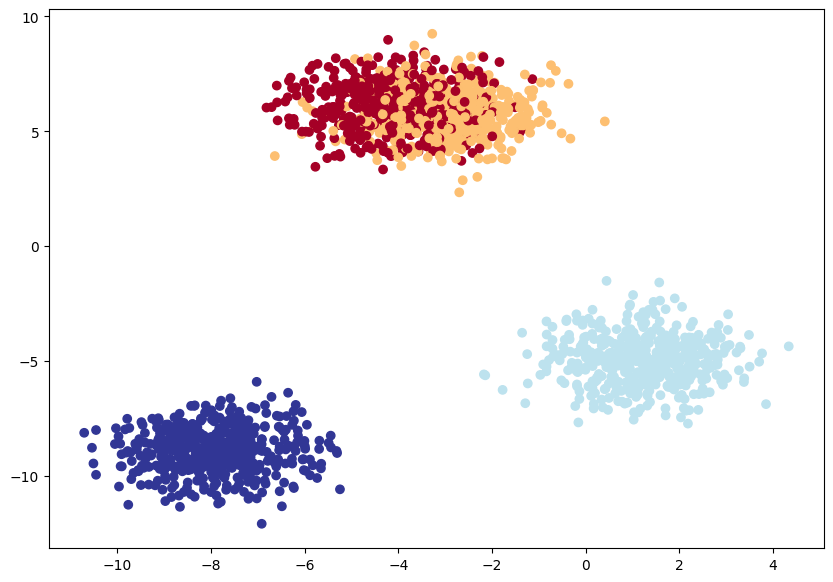

In [159]:
# let's test our modest ANN on a multi-classification problem
from sklearn.datasets import make_blobs

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=2000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=11
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [160]:
m3 = ANN(input_shape=NUM_FEATURES, num_classes=NUM_CLASSES, epochs=400, epochs_per_log=10)
m3.train_model(X_blob_train, y_blob_train, X_blob_test, y_blob_test)

The Train loss after 10 epochs: 0.937. The train metric after 10 epochs: 50.6
The Test loss after 10 epochs: 0.925. The test metric after 10 epochs: 48.0

The Train loss after 20 epochs: 0.753. The train metric after 20 epochs: 50.5
The Test loss after 20 epochs: 0.766. The test metric after 20 epochs: 48.0

The Train loss after 30 epochs: 0.678. The train metric after 30 epochs: 53.4
The Test loss after 30 epochs: 0.693. The test metric after 30 epochs: 52.5

The Train loss after 40 epochs: 0.628. The train metric after 40 epochs: 61.1
The Test loss after 40 epochs: 0.642. The test metric after 40 epochs: 60.3

The Train loss after 50 epochs: 0.59. The train metric after 50 epochs: 69.4
The Test loss after 50 epochs: 0.604. The test metric after 50 epochs: 69.7

The Train loss after 60 epochs: 0.559. The train metric after 60 epochs: 75.3
The Test loss after 60 epochs: 0.572. The test metric after 60 epochs: 74.5

The Train loss after 70 epochs: 0.534. The train metric after 70 epochs

In [161]:
# let's extract the predicitons
predictions = m3.test_model(X_blob_test, y_blob_test)

# use built in function to measure the model's accuracy
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics
    from torchmetrics import Accuracy


torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(predictions, y_blob_test)


tensor(0.8525, device='cuda:0')